In [1]:
import numpy as np
import pandas as pd
import s3fs
import boto3
import snowflake.connector
import matplotlib.pyplot as plt
from datetime import date, timedelta, datetime
from sf import sf_connection
pd.options.display.float_format = '{:20,.2f}'.format
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>")) # wide notebook display
%matplotlib inline

In [3]:
conn = sf_connection()

In [4]:
diy_discount_reduced_query = f"""    
   
     select
        INDV_ID,
        max(LOYALTY_NUMBER) as LOYALTY_NUMBER,
        count(distinct TRANSACTION_IDENTIFIER) as TX_COUNT,
        sum(USED_SP_DISCOUNT) as SP_COUNT,
        sum(USED_AF_DISCOUNT) as AF_COUNT,
        sum(USED_ANY_DISCOUNT) as DISCOUNT_COUNT,
        sum(COUPON_DISCOUNT_PRORATION_AMT*USED_SP_DISCOUNT) as COUPON_DISCOUNT_PRORATION_AMT, 
        sum(POS_SALES_DISCOUNT_AMOUNT*USED_AF_DISCOUNT) as POS_SALES_DISCOUNT_AMOUNT
        
        
        
    from
        
    
    (select
        TRANSACTION_IDENTIFIER,
        max(INDV_ID) as INDV_ID,
        max(MAX_LOYALTY_NUMBER) as LOYALTY_NUMBER,
        max(COUPON_CEV_ID) as COUPON_CEV_ID,
        sum(COUPON_DISCOUNT_PRORATION_AMT) as COUPON_DISCOUNT_PRORATION_AMT,
        sum(POS_SALES_DISCOUNT_AMOUNT) as POS_SALES_DISCOUNT_AMOUNT,
        max(case when COUPON_DISCOUNT_PRORATION_AMT > 0 and COUPON_TYPE is null then 1 else 0 end) as USED_SP_DISCOUNT,
        max(case when POS_SALES_DISCOUNT_AMOUNT > 0 then 1 else 0 end) as USED_AF_DISCOUNT,
        case when (USED_SP_DISCOUNT+USED_AF_DISCOUNT)>0 then 1 else 0 end as USED_ANY_DISCOUNT        

        
        
    from
    
    (select distinct
        INDV_ID,
        TRANSACTION_IDENTIFIER,
        COUPON_CEV_ID,
        LOYALTY_NUMBER,
        COUPON_DISCOUNT_PRORATION_AMT,
        POS_SALES_DISCOUNT_AMOUNT,
        max(LOYALTY_NUMBER) over (partition by INDV_ID) as MAX_LOYALTY_NUMBER,
        COUPON_TYPE
    from PEDW.SALES_PROTECTED.FACT_ITEM_TRANSACTION_SALES_V as fits
    
    inner join
    (select distinct
        TRANSACTION_ID,
        SEQ_NUMBER, INDV_ID,
        TRAN_DATE 
    from PEDW.SALES_PROTECTED.FACT_ITEM_TRANSACTION_SALES_EXTN_V
    where TRAN_DATE >= '2020-03-01' and TRAN_DATE <= '2021-02-28'
    ) as fits_extn
    on fits.TRANSACTION_IDENTIFIER=fits_extn.TRANSACTION_ID and fits.SEQ_NUMBER=fits_extn.SEQ_NUMBER
    
    left join
    (select distinct reward_type, case when reward_type in ('Save5Off5','Save10Off10','Save15Off15','Save20Off20') then 'SP 2.0'
          when reward_type in ('Save10Off40', 'Save20Off50', 'Save40Off100', 'Save5Off20') then 'SP 1.0'
          end as coupon_type,
          b.*
        from CUSTOMER_PROTECTED.SP_REWARD_HISTORY_V as a
        inner join CUSTOMER_PROTECTED.DIM_CAMPAIGN_EVENT_V as b
        on a.coupon_code = b.campaign_event_code
        where full_date >= '2017-12-01' and (reward_type in ('Save10Off40', 'Save20Off50', 'Save40Off100', 'Save5Off20')
                                           or reward_type in ('Save10Off10', 'Save15Off15', 'Save20Off20', 'Save5Off5'))
        ) as rewards
        on fits.coupon_cev_id = rewards.campaign_event_id
    where fits.TRAN_DATE >= '2020-03-01' and fits.TRAN_DATE <= '2021-02-28' and SALES_CHANNEL_IDENTIFIER in (1,3)
    and TRANSACTION_CLASS_FLAG = 'S' and TRAN_COUNT_IND = 'Y' and INDV_ID is not null)
    
    group by TRANSACTION_IDENTIFIER order by TRANSACTION_IDENTIFIER)
    
    group by INDV_ID order by INDV_ID
    
    
    

 """

### corrected

In [5]:
labels = pd.read_sql(diy_discount_reduced_query, conn)

In [6]:
len(labels)

22327757

In [7]:
labels.head()

INDV_ID    LOYALTY_NUMBER  TX_COUNT  SP_COUNT  AF_COUNT  DISCOUNT_COUNT  \
0         -1  7770431234521987       522         2        82              84   
1  112158814                -1         2         0         0               0   
2  112158815  7770431338291065         7         0         0               0   
3  112158822                -1         1         0         1               1   
4  112158824  7770000007985778         3         0         0               0   

   COUPON_DISCOUNT_PRORATION_AMT  POS_SALES_DISCOUNT_AMOUNT  
0                           5.44                     755.56  
1                           0.00                       0.00  
2                           0.00                       0.00  
3                           0.00                      50.00  
4                           0.00                       0.00

### End Filter

In [8]:
labels.mean()

INDV_ID                                   450,946,806.84
LOYALTY_NUMBER                  3,973,543,086,322,170.00
TX_COUNT                                            3.25
SP_COUNT                                            0.01
AF_COUNT                                            0.64
DISCOUNT_COUNT                                      0.64
COUPON_DISCOUNT_PRORATION_AMT                       0.12
POS_SALES_DISCOUNT_AMOUNT                           7.85
dtype: float64

In [9]:
labels.sum()

INDV_ID                                 10,068,630,723,131,720.00
LOYALTY_NUMBER                  88,720,304,460,431,433,400,320.00
TX_COUNT                                            72,672,325.00
SP_COUNT                                               173,180.00
AF_COUNT                                            14,237,457.00
DISCOUNT_COUNT                                      14,395,083.00
COUPON_DISCOUNT_PRORATION_AMT                        2,779,622.64
POS_SALES_DISCOUNT_AMOUNT                          175,342,463.64
dtype: float64

In [10]:
len(labels)

22327757

In [11]:
labels['DISCOUNT_FRACTION'] = labels['DISCOUNT_COUNT']/labels['TX_COUNT']

In [12]:
len(labels[labels.DISCOUNT_FRACTION > 0])

5532353

In [13]:
5532353/22327757

0.24777916563674532

In [14]:
multiple = labels[labels.TX_COUNT > 1]

In [15]:
len(multiple)

11473986

### One and done

In [16]:
22327757 - 11473986

10853771

In [17]:
len(multiple[multiple.DISCOUNT_FRACTION > 0])

3528341

In [18]:
3528341/11473986

0.3075078704122525

In [19]:
multiple = labels[labels.TX_COUNT > 2]

In [20]:
len(multiple)

7148079

In [21]:
len(multiple[multiple.DISCOUNT_FRACTION > 0])

2573687

In [22]:
2573687/7148079

0.3600529596832939

array([[<AxesSubplot:title={'center':'DISCOUNT_FRACTION'}>]], dtype=object)

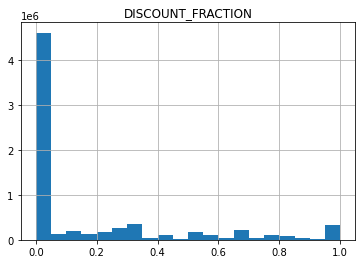

In [23]:
multiple.hist(column='DISCOUNT_FRACTION', bins=20, density=False)

In [24]:
pd.cut(multiple['DISCOUNT_FRACTION'], 20).value_counts()

(-0.001, 0.05]    4614354
(0.3, 0.35]        343401
(0.95, 1.0]        320300
(0.15, 0.2]        250282
(0.2, 0.25]        233461
(0.65, 0.7]        218698
(0.1, 0.15]        170452
(0.45, 0.5]        167260
(0.05, 0.1]        142297
(0.7, 0.75]        126063
(0.35, 0.4]        106189
(0.55, 0.6]         98089
(0.75, 0.8]         71978
(0.25, 0.3]         62341
(0.85, 0.9]         52346
(0.4, 0.45]         48988
(0.8, 0.85]         46223
(0.6, 0.65]         35760
(0.5, 0.55]         20105
(0.9, 0.95]         19492
Name: DISCOUNT_FRACTION, dtype: int64

In [25]:
labels.mean()

INDV_ID                                   450,946,806.84
LOYALTY_NUMBER                  3,973,543,086,322,170.00
TX_COUNT                                            3.25
SP_COUNT                                            0.01
AF_COUNT                                            0.64
DISCOUNT_COUNT                                      0.64
COUPON_DISCOUNT_PRORATION_AMT                       0.12
POS_SALES_DISCOUNT_AMOUNT                           7.85
DISCOUNT_FRACTION                                   0.18
dtype: float64

In [26]:
labels.head()

INDV_ID    LOYALTY_NUMBER  TX_COUNT  SP_COUNT  AF_COUNT  DISCOUNT_COUNT  \
0         -1  7770431234521987       522         2        82              84   
1  112158814                -1         2         0         0               0   
2  112158815  7770431338291065         7         0         0               0   
3  112158822                -1         1         0         1               1   
4  112158824  7770000007985778         3         0         0               0   

   COUPON_DISCOUNT_PRORATION_AMT  POS_SALES_DISCOUNT_AMOUNT  \
0                           5.44                     755.56   
1                           0.00                       0.00   
2                           0.00                       0.00   
3                           0.00                      50.00   
4                           0.00                       0.00   

     DISCOUNT_FRACTION  
0                 0.16  
1                 0.00  
2                 0.00  
3                 1.00  
4                 0.00

In [27]:
labels.loc[labels['DISCOUNT_FRACTION'] > 0, 'zero'] = 1
labels.loc[labels['DISCOUNT_FRACTION'] > 0.25, 'quarter'] = 1
labels.loc[labels['DISCOUNT_FRACTION'] > 0.5, 'half'] = 1
labels.loc[labels['DISCOUNT_FRACTION'] > 0.75, '3quarter'] = 1

### A 1 label indicates that if you defined discount sensitivity as using a discount greater than or equal to the threshold, the customer is senstitive to a discount

In [28]:
labels.isnull().sum()

INDV_ID                                 0
LOYALTY_NUMBER                          0
TX_COUNT                                0
SP_COUNT                                0
AF_COUNT                                0
DISCOUNT_COUNT                          0
COUPON_DISCOUNT_PRORATION_AMT           0
POS_SALES_DISCOUNT_AMOUNT               0
DISCOUNT_FRACTION                       0
zero                             16795404
quarter                          17631858
half                             18883448
3quarter                         19382163
dtype: int64

In [29]:
labels.fillna(0, inplace=True)

### A 1 in the label column indicates not discount sensitive if we define discount sensitivity and using a discount at the fraction specified

In [30]:
labels.dtypes

INDV_ID                            int64
LOYALTY_NUMBER                     int64
TX_COUNT                           int64
SP_COUNT                           int64
AF_COUNT                           int64
DISCOUNT_COUNT                     int64
COUPON_DISCOUNT_PRORATION_AMT    float64
POS_SALES_DISCOUNT_AMOUNT        float64
DISCOUNT_FRACTION                float64
zero                             float64
quarter                          float64
half                             float64
3quarter                         float64
dtype: object

In [31]:
features_and_labels = labels[['INDV_ID', 'TX_COUNT', 'DISCOUNT_FRACTION', 'zero', 'quarter', 'half', '3quarter']].copy()

In [32]:
cols = list(features_and_labels.columns)

In [33]:
for column in cols:
    if column not in ['INDV_ID', 'DISCOUNT_FRACTION']:
        features_and_labels.loc[:,column] = features_and_labels[column].astype('int').copy()

In [34]:
features_and_labels.dtypes

INDV_ID                int64
TX_COUNT               int64
DISCOUNT_FRACTION    float64
zero                   int64
quarter                int64
half                   int64
3quarter               int64
dtype: object

In [35]:
features_and_labels.to_csv('s3://aap-aiexpzone-nonpii-mktg-general-results-prod/DiscountPreference/test/discount_lables.csv', header=True, index=False)

In [36]:
features_and_labels.head(100)

INDV_ID  TX_COUNT    DISCOUNT_FRACTION  zero  quarter  half  3quarter
0          -1       522                 0.16     1        0     0         0
1   112158814         2                 0.00     0        0     0         0
2   112158815         7                 0.00     0        0     0         0
3   112158822         1                 1.00     1        1     1         1
4   112158824         3                 0.00     0        0     0         0
5   112158828         1                 1.00     1        1     1         1
6   112158841         4                 0.25     1        0     0         0
7   112158847         3                 0.00     0        0     0         0
8   112158853         9                 0.78     1        1     1         1
9   112158866         2                 0.00     0        0     0         0
10  112158904         1                 1.00     1        1     1         1
11  112158942         2                 0.00     0        0     0         0
12  112158947        11                 0.18     1        0     0         0
13  112158950         8                 0.50     1        1     0         0
14  112158960         5                 0.20     1        0     0         0
15  112158971         8                 0.12     1        0     0         0
16  112158972         1                 0.00     0        0     0         0
17  112158978        13                 0.00     0        0     0         0
18  112158980         3                 0.00     0        0     0         0
19  112158981         4                 0.75     1        1     1         0
20  112158998        11                 0.00     0        0     0         0
21  112159000         2                 0.00     0        0     0         0
22  112159013         1                 0.00     0        0     0         0
23  112159015        34                 0.29     1        1     0         0
24  112159028         3                 0.33     1        1     0         0
25  112159038        20                 0.40     1        1     0         0
26  112159045         4                 0.75     1        1     1         0
27  112159048         2                 0.00     0        0     0         0
28  112159053         6                 0.00     0        0     0         0
29  112159094         2                 0.00     0        0     0         0
30  112159136         5                 0.00     0        0     0         0
31  112159147         2                 0.00     0        0     0         0
32  112159151         2                 0.00     0        0     0         0
33  112159186         3                 0.00     0        0     0         0
34  112159207         1                 0.00     0        0     0         0
35  112159208         8                 0.00     0        0     0         0
36  112159226         4                 0.00     0        0     0         0
37  112159236         1                 1.00     1        1     1         1
38  112159238         1                 0.00     0        0     0         0
39  112159248         4                 1.00     1        1     1         1
40  112159266         3                 0.00     0        0     0         0
41  112159280        10                 0.00     0        0     0         0
42  112159307         3                 1.00     1        1     1         1
43  112159313         1                 0.00     0        0     0         0
44  112159315         2                 0.00     0        0     0         0
45  112159327        18                 0.22     1        0     0         0
46  112159328        11                 0.00     0        0     0         0
47  112159330         2                 0.00     0        0     0         0
48  112159340        15                 0.00     0        0     0         0
49  112159353         4                 0.75     1        1     1         0
50  112159357         1                 0.00     0        0     0         0
51  112159389         1                 0.00     0    

In [37]:
len(features_and_labels)

22327757

In [38]:
features_and_labels.sum()

INDV_ID             10,068,630,723,131,720.00
TX_COUNT                        72,672,325.00
DISCOUNT_FRACTION                3,922,459.46
zero                             5,532,353.00
quarter                          4,695,899.00
half                             3,444,309.00
3quarter                         2,945,594.00
dtype: float64

In [43]:
5532353/22327757

0.24777916563674532

In [44]:
4695899/22327757

0.21031664757010746

In [45]:
3444309/22327757

0.1542613080212222

In [46]:
2945594/22327757

0.13192520860917645